In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
import json
import time
from collections import defaultdict

import ipywidgets as widgets
import laser_pointer as lp
import matplotlib.pyplot as plt
import mpl_interactions.ipyplot as iplt
import numpy as np
import sidecar
from mpl_interactions import hyperslicer
from pycromanager import Acquisition, multi_d_acquisition_events
from raman_control import *
from tqdm.auto import tqdm

In [2]:
galvo, shutter, open_shutter, close_shutter, close_daq = setup_laser_control()
auto, experiment, set_value, set_rm_exposure = setup_lightfield()
bridge, core, snap_image, collect_bf_images = setup_scope()


def shutdown():
    close_daq()
    auto.Dispose()

In [3]:
capture_rm_grid, collect_spectra = create_collection_functions(
    galvo, shutter, experiment, set_rm_exposure, open_shutter, nidaqmx
)

In [4]:
calibrate = create_calibrate(capture_rm_grid, snap_image, lp)

In [7]:
fit_calibration, lp_bf, lp_rm = calibrate(75)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
transform_pointer, bfx_to_rmx, bfy_to_rmy, inverse_x, inverse_y = fit_calibration()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
xy, z = position_file_to_coords("pos-oct28-2.pos")

In [14]:
xyz = np.hstack([xy, z[:, None]])

In [24]:
images = collect_bf_images(xy, list(z))

In [27]:
plt.figure()
hyperslicer(images)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
overlay = lp.make_overlay(images.shape[1:], inverse_x, inverse_y)

In [29]:
pointers = {}
pointers[0] = lp.pointer(images[0])
pointers[0].ax.imshow(overlay)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
pointers[1] = lp.pointer(images[1])
pointers[1].ax.imshow(overlay)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [34]:
bead_positions = {}
for i in range(2):
    bead_positions[i] = transform_pointer(pointers[i])

In [37]:
spectra = collect_spectra(bead_positions[1])

In [40]:
plt.figure()
plt.plot(spectra.T)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [43]:
events = multi_d_acquisition_events(
    xyz_positions=xyz,
    z_start=-3,
    z_end=3,
    z_step=1,
    channel_group="UPLSAPO40X",
    channels=["BF", "GFP"],
)

In [44]:
rm_data = defaultdict(dict)
sc.clear_output()


def f(event):
    if event["axes"]["z"] == 5 and event["channel"]["config"] == "BF":
        with sc:
            print("starting raman")
            rm_data[axes["position"]][axes["z"]] = capture_rm_grid(25)
            print("done raman")
            print(event)
    return event


with Acquisition(directory="z-stack-test", name="heck", post_hardware_hook_fn=f) as acq:
    dataset = acq.acquire(events)

In [49]:
sc = sidecar.Sidecar(title="function output")

In [53]:
rm_data = defaultdict(dict)
sc.clear_output()


def f(event):
    if event["axes"]["z"] == 3 and event["channel"]["config"] == "BF":
        axes = event["axes"]
        with sc:
            print("starting raman")
            print(axes["position"])
            rm_data[axes["position"]][axes["z"]] = collect_spectra(
                bead_positions[axes["position"]]
            )
            print("done raman")
            print(event)
    return event

In [54]:
with Acquisition(
    directory="multi-pos-selected-rm", name="test", post_hardware_hook_fn=f
) as acq:
    dataset = acq.acquire(events)

In [52]:
bead_positions

{0: array([[ 0.19128391,  0.1606868 ,  0.12428678,  0.10687808,  0.0884143 ,
          0.07417082,  0.04990414,  0.20489564,  0.22339998,  0.06611303,
          0.07125313,  0.08256134, -0.01304446, -0.00584832, -0.03360484,
         -0.03977296, -0.04696909, -0.11173431, -0.13743479],
        [-0.11560434, -0.10980144, -0.09925071, -0.07762172, -0.16572031,
         -0.13776087, -0.16466523, -0.14513435, -0.11943387,  0.0440212 ,
          0.01318062, -0.01149184, -0.0145759 , -0.05055657, -0.07625706,
         -0.04438846, -0.00635174,  0.07691782,  0.05532942]]),
 1: array([[ 0.03626078,  0.06076216,  0.04346707,  0.01968631, -0.00085161,
          0.02833386,  0.05968122,  0.07257976,  0.03349803,  0.00206273,
          0.05133969,  0.08447419,  0.11590949,  0.12695433,  0.15329201,
          0.14309678,  0.11590949,  0.0878726 ],
        [ 0.10433505,  0.13316021,  0.15910285,  0.13099832,  0.06722265,
          0.05641322,  0.06614171,  0.0359795 ,  0.02238586,  0.0359795 ,
     

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

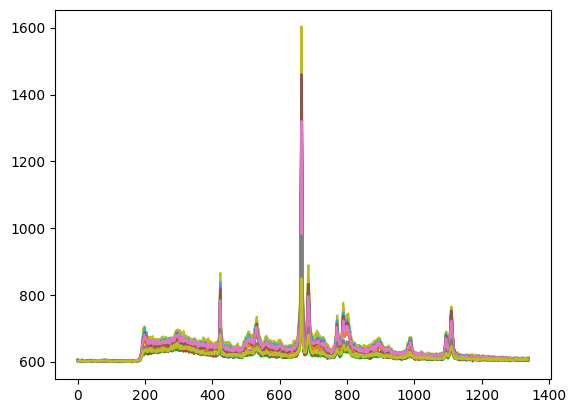

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

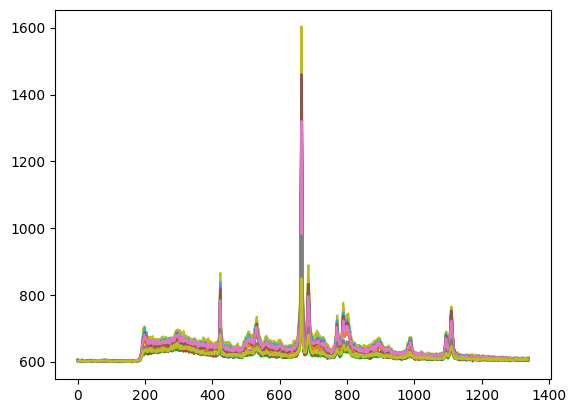

In [58]:
fig = plt.figure()
plt.plot(rm_data[0][3].T)
display(fig)
plt.figure()
plt.plot(rm_data[1][3].T)
display(fig)